## Import 

In [1]:
import os
import heapq
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns 
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold

## Dataset

In [2]:
df = pd.read_csv("social_media_vs_productivity.csv")
df.head().T

,0,1,2,3,4
age,56,46,32,60,25
gender,Male,Male,Male,Female,Male
job_type,Unemployed,Health,Finance,Unemployed,IT
daily_social_media_time,4.18094,3.249603,NaN,NaN,NaN
social_platform_preference,Facebook,Twitter,Twitter,Facebook,Telegram
number_of_notifications,61,59,57,59,66
work_hours_per_day,6.753558,9.169296,7.910952,6.355027,6.214096
perceived_productivity_score,8.040464,5.063368,3.861762,2.916331,8.868753
actual_productivity_score,7.291555,5.165093,3.474053,1.774869,NaN
stress_level,4.0,7.0,4.0,6.0,7.0


## Feature & Target

In [3]:
# feature & target
all_features = ['age', 'gender', 'job_type', 'daily_social_media_time',
       'social_platform_preference', 'number_of_notifications',
       'work_hours_per_day', 'perceived_productivity_score', 'stress_level',
       'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work',
       'uses_focus_apps', 'has_digital_wellbeing_enabled',
       'coffee_consumption_per_day', 'days_feeling_burnout_per_month',
       'weekly_offline_hours', 'job_satisfaction_score']
target = 'actual_productivity_score'

In [4]:
# remove missing Y
initial_rows = df.shape[0]
print(f"Original DataFrame rows: {initial_rows}")
print(f"NaNs in target '{target}' BEFORE dropping: {df[target].isnull().sum()}")

df.dropna(subset=[target], inplace=True)

rows_after_target_nan_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_target_nan_drop} rows with missing '{target}' values.")
print(f"DataFrame rows after target NaN drop: {rows_after_target_nan_drop}")
print(f"NaNs in target '{target}' AFTER dropping: {df[target].isnull().sum()}")

Original DataFrame rows: 30000
NaNs in target 'actual_productivity_score' BEFORE dropping: 2365
Dropped 2365 rows with missing 'actual_productivity_score' values.
DataFrame rows after target NaN drop: 27635
NaNs in target 'actual_productivity_score' AFTER dropping: 0


In [5]:
# outlier
print("\n--- Performing Outlier Removal (IQR Method) ---")
numerical_cols_for_outliers = df[all_features].select_dtypes(include=np.number).columns.tolist()
if target not in numerical_cols_for_outliers:
    numerical_cols_for_outliers.append(target)

df_before_outlier_removal = df.shape[0]
print(f"Rows before outlier removal: {df_before_outlier_removal}")

for col in numerical_cols_for_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound) | df[col].isna()]
    print(f"  - Applied IQR to '{col}'. Rows remaining: {df.shape[0]}")

rows_after_outlier_removal = df.shape[0]
removed_rows = df_before_outlier_removal - rows_after_outlier_removal
print(f"Total rows removed due to outliers: {removed_rows}")
print(f"DataFrame rows after outlier removal: {rows_after_outlier_removal}")


--- Performing Outlier Removal (IQR Method) ---
Rows before outlier removal: 27635
  - Applied IQR to 'age'. Rows remaining: 27635
  - Applied IQR to 'daily_social_media_time'. Rows remaining: 27439
  - Applied IQR to 'number_of_notifications'. Rows remaining: 27197
  - Applied IQR to 'work_hours_per_day'. Rows remaining: 27109
  - Applied IQR to 'perceived_productivity_score'. Rows remaining: 27109
  - Applied IQR to 'stress_level'. Rows remaining: 27109
  - Applied IQR to 'sleep_hours'. Rows remaining: 27109
  - Applied IQR to 'screen_time_before_sleep'. Rows remaining: 27020
  - Applied IQR to 'breaks_during_work'. Rows remaining: 27020
  - Applied IQR to 'coffee_consumption_per_day'. Rows remaining: 26905
  - Applied IQR to 'days_feeling_burnout_per_month'. Rows remaining: 26905
  - Applied IQR to 'weekly_offline_hours'. Rows remaining: 26799
  - Applied IQR to 'job_satisfaction_score'. Rows remaining: 26799
  - Applied IQR to 'actual_productivity_score'. Rows remaining: 26799
Tot

In [6]:
# X & Y
X = df[all_features].copy()
y = df[target]

In [7]:
# numeric & catgorical
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

## Missing Value

In [8]:
# check missing X
print("\n--- Initial Missing Values Across All Columns ---")
missing_info = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_info, 'Missing %': missing_percentage})
print(missing_df.sort_values(by='Missing %', ascending=False))
print("-" * 50) 


--- Initial Missing Values Across All Columns ---
                                Missing Count  Missing %
daily_social_media_time                  2490   9.291391
job_satisfaction_score                   2434   9.082428
sleep_hours                              2334   8.709280
screen_time_before_sleep                 1990   7.425650
stress_level                             1717   6.406955
perceived_productivity_score             1446   5.395724
number_of_notifications                     0   0.000000
work_hours_per_day                          0   0.000000
actual_productivity_score                   0   0.000000
gender                                      0   0.000000
social_platform_preference                  0   0.000000
job_type                                    0   0.000000
breaks_during_work                          0   0.000000
uses_focus_apps                             0   0.000000
has_digital_wellbeing_enabled               0   0.000000
coffee_consumption_per_day           

## Tran-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Train set shape: (21439, 18), Test set shape: (5360, 18)


## Pre-Processing Pipelines

In [10]:
# numeric (imputer, scaler)
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# categorical (imputer, encoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [11]:
# fit & transform
print("Fitting and transforming data with preprocessor...")
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
print(f"X_train_transformed shape: {X_train_transformed.shape}")

Fitting and transforming data with preprocessor...
X_train_transformed shape: (21439, 29)


In [12]:
# preview result
feature_names_out = preprocessor.get_feature_names_out()
if hasattr(X_train_transformed, 'toarray'):
    X_transformed_dense = X_train_transformed.toarray()
else:
    X_transformed_dense = X_train_transformed
X_transformed_df = pd.DataFrame(X_transformed_dense, columns=feature_names_out)

print(f"\nShape of Transformed X DataFrame: {X_transformed_df.shape}")
print("\n--- First 5 rows of Transformed X (as DataFrame) ---")
X_transformed_df.head().T


Shape of Transformed X DataFrame: (21439, 29)

--- First 5 rows of Transformed X (as DataFrame) ---


,0,1,2,3,4
num__age,0.763962,-0.971418,-1.477570,-0.899110,-0.031420
num__daily_social_media_time,-0.025607,0.359916,-1.689747,2.622637,-0.195212
num__number_of_notifications,1.769623,0.962174,1.635048,-0.383575,-0.787300
num__work_hours_per_day,-0.137377,0.694431,0.380403,0.080813,0.892239
num__perceived_productivity_score,1.002713,0.044908,1.200149,-1.512239,0.955395
num__stress_level,0.170423,0.456786,-1.261390,-0.903437,0.886330
num__sleep_hours,-1.406200,0.808483,-0.962044,0.543425,-0.081787
num__screen_time_before_sleep,0.066732,-1.352777,0.108706,-0.643638,-1.630811
num__breaks_during_work,-0.627142,-0.942404,0.633906,-0.627142,0.318644
num__coffee_consumption_per_day,-0.714579,0.014591,-0.714579,-1.443750,-0.714579


In [13]:
# export
EXPORT_PATH = "model_preprocessor.pkl"
joblib.dump(preprocessor, EXPORT_PATH)
print(f"Preprocessor saved to: {EXPORT_PATH}")

Preprocessor saved to: model_preprocessor.pkl


## Modeling (Seach Algorithm)

In [14]:
# parameters
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': np.linspace(0.01, 0.2, 10), 
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [0, 0.001, 0.01, 0.1],
}

In [15]:
# score metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [16]:
# random search CV
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_distributions,
                                   n_iter=50, # Try 50 random combinations
                                   cv=5,      # 5-fold cross-validation
                                   scoring=scorer,
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)

In [17]:
# fit
print(f"Starting Randomized Search for {random_search.n_iter} iterations...")
random_search.fit(X_train_transformed, y_train)
print("Randomized Search complete.")

Starting Randomized Search for 50 iterations...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Randomized Search complete.


In [18]:
# random search result
results_df = pd.DataFrame(random_search.cv_results_)

columns_to_show = [
    'param_n_estimators', 'param_learning_rate', 'param_max_depth',
    'param_subsample', 'param_colsample_bytree', 'param_gamma',
    'param_reg_alpha', 'param_reg_lambda',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]
results_df_sorted = results_df[columns_to_show].sort_values(by='rank_test_score').reset_index(drop=True)

results_df_sorted['mean_test_mse'] = -results_df_sorted['mean_test_score']
results_df_sorted = results_df_sorted.drop(columns=['mean_test_score'])
print(results_df_sorted.to_string())


    param_n_estimators  param_learning_rate  param_max_depth  param_subsample  param_colsample_bytree  param_gamma  param_reg_alpha  param_reg_lambda  std_test_score  rank_test_score  mean_test_mse
0                  200             0.073333                3              0.6                     0.7          0.0            0.100             0.100        0.010023                1       0.291532
1                  500             0.031111                3              0.8                     0.6          0.0            0.001             0.001        0.010056                2       0.291629
2                  400             0.010000                4              0.7                     1.0          0.0            0.010             0.000        0.009417                3       0.291987
3                  100             0.073333                3              0.9                     0.7          0.3            0.000             0.000        0.009901                4       0.292167
4         

In [19]:
# best parameter
best_params_rs = random_search.best_params_
best_mse_rs = -random_search.best_score_ 
print(f"\nRandomized Search Best Parameters: {best_params_rs}")
print(f"Randomized Search Best CV MSE: {best_mse_rs:.4f}")


Randomized Search Best Parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.07333333333333333, 'gamma': 0, 'colsample_bytree': 0.7}
Randomized Search Best CV MSE: 0.2915


In [20]:
# best model
best_model_rs = random_search.best_estimator_
y_pred = best_model_rs.predict(X_test_transformed)
test_mse_rs = mean_squared_error(y_test, y_pred)
test_r2_rs = r2_score(y_test, y_pred)

In [21]:
# export
EXPORT_PATH = "model_regressor.pkl"
joblib.dump(best_model_rs, EXPORT_PATH)
print(f"Model saved to: {EXPORT_PATH}")

Model saved to: model_regressor.pkl


In [22]:
# eval
print(f"\nRandomized Search Test Set Performance:")
print(f"  Mean Squared Error (MSE): {test_mse_rs:.4f}")
print(f"  R2 Score: {test_r2_rs:.4f}")


Randomized Search Test Set Performance:
  Mean Squared Error (MSE): 0.2916
  R2 Score: 0.9181


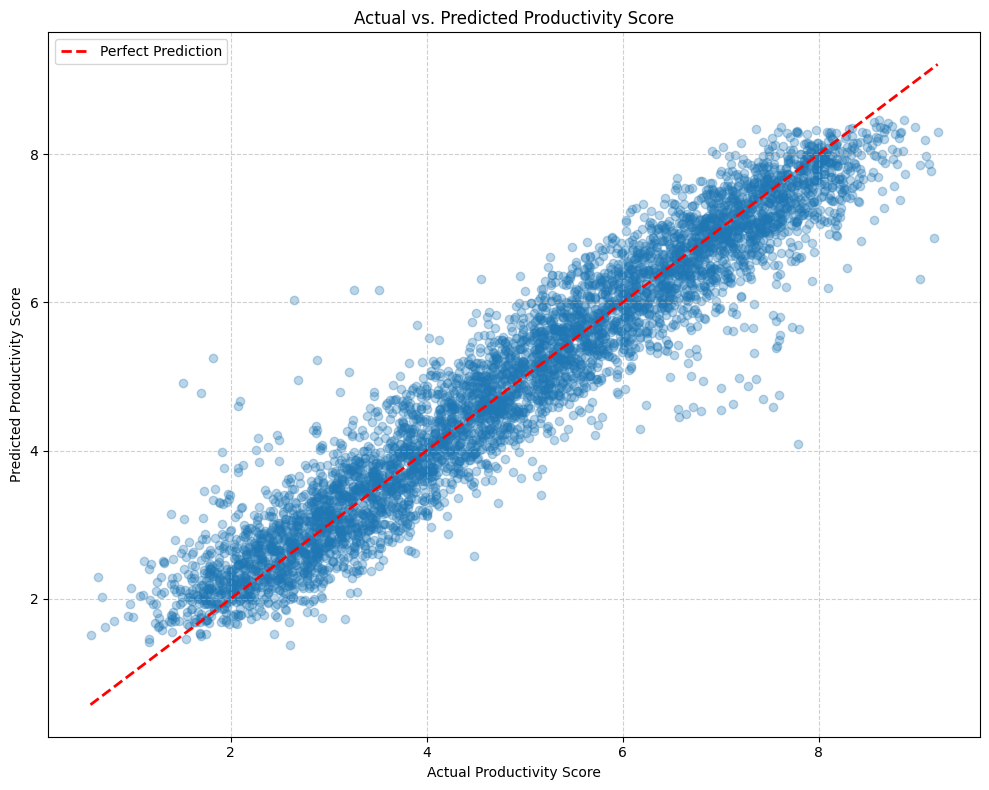

In [23]:
# visualize
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Actual vs. Predicted Productivity Score')
plt.xlabel('Actual Productivity Score')
plt.ylabel('Predicted Productivity Score')
plt.grid(True, linestyle='--', alpha=0.6)

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()

## Modeling (Evolutionary Algorithmn)

In [24]:
# fitness & individual
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # We want to minimize MSE, so weight is -1.0
creator.create("Individual", list, fitness=creator.FitnessMin)

In [25]:
# gene generation for hyperparameter
toolbox = base.Toolbox()
toolbox.register("attr_n_estimators", random.randrange, len(param_distributions['n_estimators']))
toolbox.register("attr_learning_rate", random.randrange, len(param_distributions['learning_rate']))
toolbox.register("attr_max_depth", random.randrange, len(param_distributions['max_depth']))
toolbox.register("attr_subsample", random.randrange, len(param_distributions['subsample']))
toolbox.register("attr_colsample_bytree", random.randrange, len(param_distributions['colsample_bytree']))
toolbox.register("attr_gamma", random.randrange, len(param_distributions['gamma']))
toolbox.register("attr_reg_alpha", random.randrange, len(param_distributions['reg_alpha']))
toolbox.register("attr_reg_lambda", random.randrange, len(param_distributions['reg_lambda']))


In [26]:
# create an individual (chromosome)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_estimators,
                  toolbox.attr_learning_rate,
                  toolbox.attr_max_depth,
                  toolbox.attr_subsample,
                  toolbox.attr_colsample_bytree,
                  toolbox.attr_gamma,
                  toolbox.attr_reg_alpha,
                  toolbox.attr_reg_lambda), n=1)

# create population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [27]:
# eval function
def evaluateXGBoost(individual):
    hyperparameters = {
        'n_estimators': param_distributions['n_estimators'][individual[0]],
        'learning_rate': param_distributions['learning_rate'][individual[1]],
        'max_depth': param_distributions['max_depth'][individual[2]],
        'subsample': param_distributions['subsample'][individual[3]],
        'colsample_bytree': param_distributions['colsample_bytree'][individual[4]],
        'gamma': param_distributions['gamma'][individual[5]],
        'reg_alpha': param_distributions['reg_alpha'][individual[6]],
        'reg_lambda': param_distributions['reg_lambda'][individual[7]],
    }

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, **hyperparameters)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_transformed, y_train, scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=kf, n_jobs=-1)

    return (np.mean(scores),)

toolbox.register("evaluate", evaluateXGBoost)

In [28]:
# selection
toolbox.register("select", tools.selTournament, tournsize=3)

In [29]:
# crossover
toolbox.register("mate", tools.cxTwoPoint)


In [30]:
# mutate
def mutUniformInt(individual, low, up, indpb):
    """Mutates an individual by uniformly choosing a new random integer
    for each attribute.

    :param individual: The individual to be mutated.
    :param low: The lower bound for the random integer.
    :param up: The upper bound for the random integer.
    :param indpb: Independent probability for each attribute to be mutated.
    :returns: A tuple of one individual.
    """
    for i, idx in enumerate(individual):
        if random.random() < indpb:
            if i == 0:
                individual[i] = random.randrange(len(param_distributions['n_estimators']))
            elif i == 1:
                individual[i] = random.randrange(len(param_distributions['learning_rate']))
            elif i == 2:
                individual[i] = random.randrange(len(param_distributions['max_depth']))
            elif i == 3:
                individual[i] = random.randrange(len(param_distributions['subsample']))
            elif i == 4:
                individual[i] = random.randrange(len(param_distributions['colsample_bytree']))
            elif i == 5:
                individual[i] = random.randrange(len(param_distributions['gamma']))
            elif i == 6:
                individual[i] = random.randrange(len(param_distributions['reg_alpha']))
            elif i == 7:
                individual[i] = random.randrange(len(param_distributions['reg_lambda']))
    return individual,

toolbox.register("mutate", mutUniformInt, low=0, up=max(len(v) for v in param_distributions.values()), indpb=0.1)


In [32]:
# genetic algo parameters
POPULATION_SIZE = 50
GENERATIONS = 20
CXPB = 0.7  # Crossover probability
MUTPB = 0.2 # Mutation probability

In [35]:
random.seed(42)
population = toolbox.population(n=POPULATION_SIZE)

# statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# logbook
logbook = tools.Logbook()
logbook.header = ["gen", "nevals"] + (stats.fields if stats else [])

# evaluate initial population
print("Evaluating initial population...")
fitnesses = map(toolbox.evaluate, population)
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit
record = stats.compile(population)
logbook.record(gen=0, nevals=len(population), **record)
print(logbook.stream)

# start evolution
print(f"Starting Genetic Algorithm for {GENERATIONS} generations...")
for gen in range(1, GENERATIONS + 1):
    # select next generation
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # mutation
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # replace old population
    population[:] = offspring

    # Gather all the statistics in the logbook
    record = stats.compile(population)
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(logbook.stream)

Evaluating initial population...
gen	nevals	avg      	std      	min      	max      
0  	50    	-0.329782	0.0966263	-0.849637	-0.290212
Starting Genetic Algorithm for 20 generations...
1  	35    	-0.383153	0.153989 	-0.849637	-0.301608
2  	43    	-0.503119	0.220716 	-0.851996	-0.296473
3  	41    	-0.658586	0.21366  	-0.849648	-0.299587
4  	45    	-0.80597 	0.103302 	-0.849917	-0.328794
5  	36    	-0.848659	0.00143478	-0.851062	-0.845666
6  	40    	-0.839448	0.0728438 	-0.852462	-0.329569
7  	39    	-0.826967	0.097926  	-0.852462	-0.303373
8  	35    	-0.806645	0.144728  	-0.852489	-0.30828 
9  	44    	-0.849412	0.0127292 	-0.852893	-0.760668
10 	38    	-0.839714	0.0753323 	-0.853246	-0.3201  
11 	34    	-0.800583	0.162688  	-0.950596	-0.302444
12 	42    	-0.845338	0.0811667 	-0.950258	-0.292191
13 	32    	-0.850155	0.0662477 	-0.950596	-0.414219
14 	35    	-0.85497 	0.0817515 	-0.952648	-0.327251
15 	37    	-0.882382	0.0947076 	-0.952648	-0.306954
16 	39    	-0.913179	0.0999663 	-0.95264

In [36]:
# idendity best individual
best_individual = tools.selBest(population, 1)[0]
print("\nGenetic Algorithm Best Individual (indices):", best_individual)

# best hyperparameter
best_hyperparameters_ga = {
    'n_estimators': param_distributions['n_estimators'][best_individual[0]],
    'learning_rate': param_distributions['learning_rate'][best_individual[1]],
    'max_depth': param_distributions['max_depth'][best_individual[2]],
    'subsample': param_distributions['subsample'][best_individual[3]],
    'colsample_bytree': param_distributions['colsample_bytree'][best_individual[4]],
    'gamma': param_distributions['gamma'][best_individual[5]],
    'reg_alpha': param_distributions['reg_alpha'][best_individual[6]],
    'reg_lambda': param_distributions['reg_lambda'][best_individual[7]],
}
print("Genetic Algorithm Best Hyperparameters:", best_hyperparameters_ga)


Genetic Algorithm Best Individual (indices): [0, 0, 5, 0, 0, 0, 3, 3]
Genetic Algorithm Best Hyperparameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.1}


In [37]:
# eval metric
best_cv_mse_ga = -best_individual.fitness.values[0]
print("Genetic Algorithm Best CV MSE:", best_cv_mse_ga)

print("\nEvaluating the best GA model on the test set...")
best_model_ga = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, **best_hyperparameters_ga)
best_model_ga.fit(X_train_transformed, y_train)
y_pred = best_model_ga.predict(X_test_transformed)
test_mse_ga = mean_squared_error(y_test, y_pred)
test_r2_ga = r2_score(y_test, y_pred)

print(f"Genetic Algorithm Test MSE: {test_mse_ga:.4f}")
print(f"Genetic Algorithm Test R2: {test_r2_ga:.4f}")

Genetic Algorithm Best CV MSE: 0.9526484055431537

Evaluating the best GA model on the test set...
Genetic Algorithm Test MSE: 0.9718
Genetic Algorithm Test R2: 0.7270


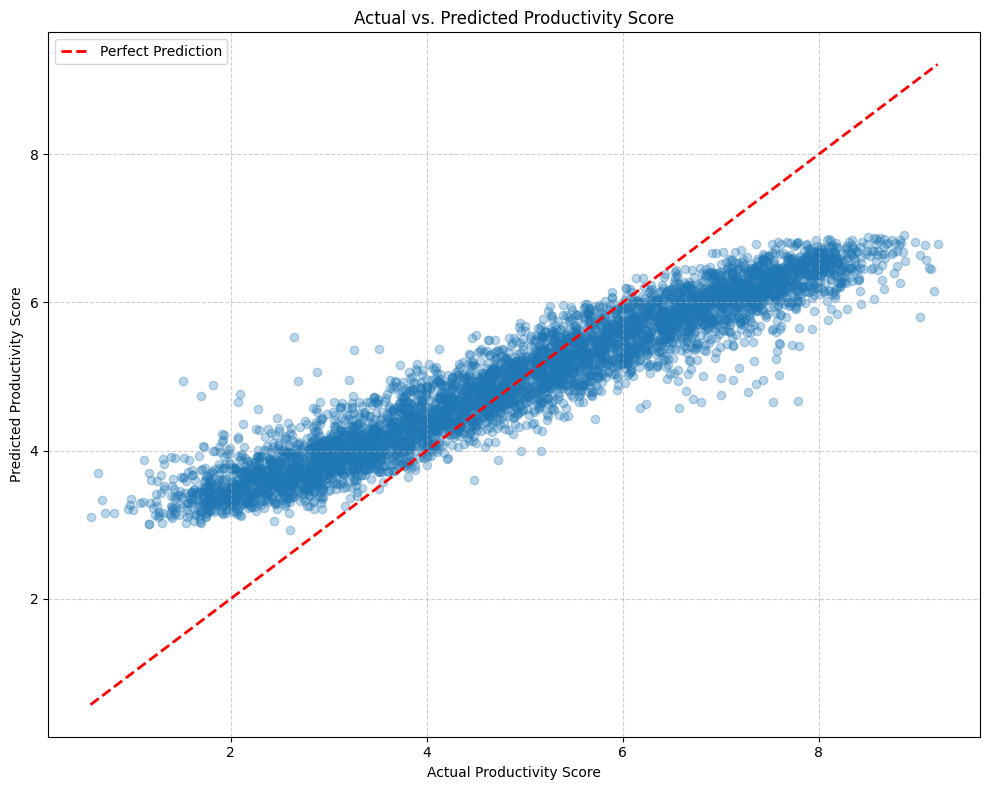

In [38]:
# visualize
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Actual vs. Predicted Productivity Score')
plt.xlabel('Actual Productivity Score')
plt.ylabel('Predicted Productivity Score')
plt.grid(True, linestyle='--', alpha=0.6)

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()